In [1]:
#Import all the necessary libraries
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import pickle
import datetime as dt
import dateutil.relativedelta as ddelta
import calendar
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%config InlineBackend.figure_format = 'svg'
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
#set up key parameters
start_date = dt.date(2013,1,1) #start of the time range for weather scraping
end_date = dt.date(2018,12,31)  #end of the time range for weather scraping
test_split = 1826 #row number where the data held out for testing starts

## Import, clean and combine basic input data

#### ---bike data

In [3]:
df_bike = pd.read_csv("Fremont_Bridge_Hourly_Bicycle_Counts_by_Month_October_2012_to_present.csv")

#1)shorten column names
df_bike.columns = ['DateTime','East','West']

#2) fill in nulls with 0s, those are the times when no people went by on either side of the bridge
df_bike = df_bike.fillna(0)

#3) convert date strings to datetime
df_bike.DateTime = pd.to_datetime(df_bike.DateTime, format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

#4) create a Date column to later aggregate by
df_bike['Date'] = df_bike['DateTime'].dt.date

#5) filter the dataset to the same dates as the scraped weather data
filt = (df_bike.DateTime >= pd.Timestamp(start_date)) & (df_bike.DateTime <= pd.Timestamp(end_date))
df_bike = df_bike[filt]

#6) now, aggregate bike counts by date
df_bike_by_day = (df_bike
 .groupby(['Date'],as_index=False)
 .agg({'East':'sum','West':'sum'})
)

#ta-da
df_bike_by_day.head()

,Date,East,West
0,2013-01-01,334.0,344.0
1,2013-01-02,931.0,904.0
2,2013-01-03,913.0,890.0
3,2013-01-04,876.0,836.0
4,2013-01-05,316.0,403.0


#### ---weather data

In [4]:
#1)read in the weather data from the pickle file we created in part 1

with open('weather2.pickle','rb') as read_file:
    weather_data = pickle.load(read_file)

#2)convert the weather data to a dataframe, add column headers, and convert date string to datetime
df_weather = pd.DataFrame(weather_data,columns=['Date','Temp-Max','Temp-Min','Temp-Avg','Departure','HDD','CDD'
                                               ,'Precipitation','New_Snow','Snow_Depth'])
df_weather.Date = pd.to_datetime(df_weather.Date, format='%Y-%m-%d', errors='coerce')
df_weather.Date = df_weather.Date.dt.date

#3)clean up non-numeric values in weather readings - T is "trace", replace with 0, 
#if M is missing for precipitation - remove record; if it's missing for snow - replace with 0
df_weather['Precipitation'] = df_weather['Precipitation'].replace('T',0)
df_weather['New_Snow'] = df_weather['New_Snow'].replace(['T','M'],0)
df_weather['Snow_Depth'] = df_weather['Snow_Depth'].replace('T',0)

#4) convert numeric values to floats
df_weather[['Temp-Max','Temp-Min','Temp-Avg'
           ,'Departure','HDD','CDD'
           ,'Precipitation','New_Snow'
           ,'Snow_Depth']] = df_weather[['Temp-Max','Temp-Min','Temp-Avg'
                                        ,'Departure','HDD','CDD'
                                        ,'Precipitation','New_Snow'
                                        ,'Snow_Depth']].applymap(lambda x: np.float(x))

df_weather.head()

,Date,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2013-01-01,41.0,27.0,34.0,-6.8,31.0,0.0,0.00,0.0,0.0
1,2013-01-02,43.0,30.0,36.5,-4.4,28.0,0.0,0.00,0.0,0.0
2,2013-01-03,44.0,29.0,36.5,-4.5,28.0,0.0,0.16,0.0,0.0
3,2013-01-04,50.0,36.0,43.0,1.9,22.0,0.0,0.10,0.0,0.0
4,2013-01-05,44.0,40.0,42.0,0.8,23.0,0.0,0.12,0.0,0.0


#### --merge

In [5]:
#merge bike and weather data
df_merged = pd.merge(df_bike_by_day, df_weather,on=['Date'])
df_merged.head()

,Date,East,West,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,2013-01-01,334.0,344.0,41.0,27.0,34.0,-6.8,31.0,0.0,0.00,0.0,0.0
1,2013-01-02,931.0,904.0,43.0,30.0,36.5,-4.4,28.0,0.0,0.00,0.0,0.0
2,2013-01-03,913.0,890.0,44.0,29.0,36.5,-4.5,28.0,0.0,0.16,0.0,0.0
3,2013-01-04,876.0,836.0,50.0,36.0,43.0,1.9,22.0,0.0,0.10,0.0,0.0
4,2013-01-05,316.0,403.0,44.0,40.0,42.0,0.8,23.0,0.0,0.12,0.0,0.0


## Engineer features

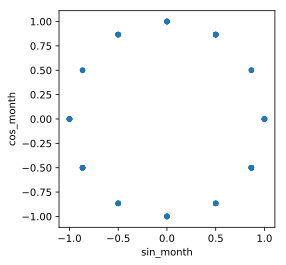

In [6]:
#1)add new columns to denote year, month, and weekday for further analysis/visualization
df_merged['Weekday'] = df_merged['Date'].map(lambda x: calendar.day_name[x.weekday()])
df_merged['Month'] = df_merged['Date'].map(lambda x: x.month)
df_merged['Year'] = df_merged['Date'].map(lambda x: x.year)

#2)transform month into two columns, sine and cosine
#all sin/cos code from here: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
df_merged['sin_month'] = np.sin(2*np.pi*df_merged.Month/12)
df_merged['cos_month'] = np.cos(2*np.pi*df_merged.Month/12)

#check conversion
df_merged.sample(100).plot.scatter('sin_month','cos_month').set_aspect('equal');

In [7]:
#3)flag holidays
#I experimented a bit with what holidays to include and ultimately boiled it down to: New Year's Day, MLK, Memorial
#Day, Independence Day, Labor Day, Thanksgiving, the day after Thanksgiving, Christmas Night, Christmas Day, 
#New Year's Eve for each year
holidays = [dt.date(2015,1,1),dt.date(2015,1,19),dt.date(2015,5,25)
           ,dt.date(2015,7,3),dt.date(2015,9,7),dt.date(2015,1,19)
           ,dt.date(2015,11,26),dt.date(2015,11,27),dt.date(2015,12,25)
           ,dt.date(2016,1,1),dt.date(2016,1,18),dt.date(2016,5,30)
           ,dt.date(2016,7,4),dt.date(2016,9,5),dt.date(2016,11,24)
           ,dt.date(2016,11,25),dt.date(2016,12,26),dt.date(2017,1,2)
           ,dt.date(2017,1,16),dt.date(2017,5,29),dt.date(2017,7,4)
           ,dt.date(2017,9,4),dt.date(2017,11,23),dt.date(2017,11,24)
           ,dt.date(2017,12,25),dt.date(2018,1,1),dt.date(2018,1,15)
           ,dt.date(2018,5,28),dt.date(2018,7,4),dt.date(2018,9,3)
           ,dt.date(2018,11,22),dt.date(2018,11,23),dt.date(2018,12,24)
           ,dt.date(2018,12,25),dt.date(2015,12,31),dt.date(2016,12,31)
           ,dt.date(2017,12,31),dt.date(2018,12,31),dt.date(2013,1,1)
           ,dt.date(2013,1,21),dt.date(2013,5,27),dt.date(2013,7,4)
           ,dt.date(2013,9,2),dt.date(2013,11,28),dt.date(2013,11,29)
           ,dt.date(2013,12,24),dt.date(2013,12,25),dt.date(2013,12,31)
           ,dt.date(2014,1,1),dt.date(2014,1,20),dt.date(2014,5,26)
           ,dt.date(2014,7,4),dt.date(2014,9,1),dt.date(2014,11,27)
           ,dt.date(2014,11,28),dt.date(2014,12,24),dt.date(2014,12,25)
           ,dt.date(2014,12,31)]

df_merged['Is_holiday'] = df_merged['Date'].isin(holidays)
df_merged['Is_holiday'] = df_merged['Is_holiday'].replace({True:1,False:0})

#4) calculate the cumulative number of bike trips per day (the final dependent variable)
# and the daily temperature delta
df_merged['EW'] = df_merged['East']+df_merged['West']
df_merged['Temp_HiLo_delta'] = df_merged['Temp-Max']-df_merged['Temp-Min']
df_merged['Weekend_rain'] = ((df_merged.Weekday=='Saturday') | (df_merged.Weekday=='Sunday')) & \
    (df_merged.Precipitation>0)
df_merged['Weekend_rain'] = df_merged['Weekend_rain'].replace({True:1,False:0})

#5) looks like there is a quadratic relationship with amount of precipitation
df_merged['Precip^2'] = df_merged['Precipitation']**2

In [8]:
#full final dataset
df_merged.head()

,Date,East,West,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth,Weekday,Month,Year,sin_month,cos_month,Is_holiday,EW,Temp_HiLo_delta,Weekend_rain,Precip^2
0,2013-01-01,334.0,344.0,41.0,27.0,34.0,-6.8,31.0,0.0,0.00,0.0,0.0,Tuesday,1,2013,0.5,0.866025,1,678.0,14.0,0,0.0000
1,2013-01-02,931.0,904.0,43.0,30.0,36.5,-4.4,28.0,0.0,0.00,0.0,0.0,Wednesday,1,2013,0.5,0.866025,0,1835.0,13.0,0,0.0000
2,2013-01-03,913.0,890.0,44.0,29.0,36.5,-4.5,28.0,0.0,0.16,0.0,0.0,Thursday,1,2013,0.5,0.866025,0,1803.0,15.0,0,0.0256
3,2013-01-04,876.0,836.0,50.0,36.0,43.0,1.9,22.0,0.0,0.10,0.0,0.0,Friday,1,2013,0.5,0.866025,0,1712.0,14.0,0,0.0100
4,2013-01-05,316.0,403.0,44.0,40.0,42.0,0.8,23.0,0.0,0.12,0.0,0.0,Saturday,1,2013,0.5,0.866025,0,719.0,4.0,1,0.0144


## Visualize data for analysis/presentation

Text(0.5,1,'Average # of bike trips per weekday')

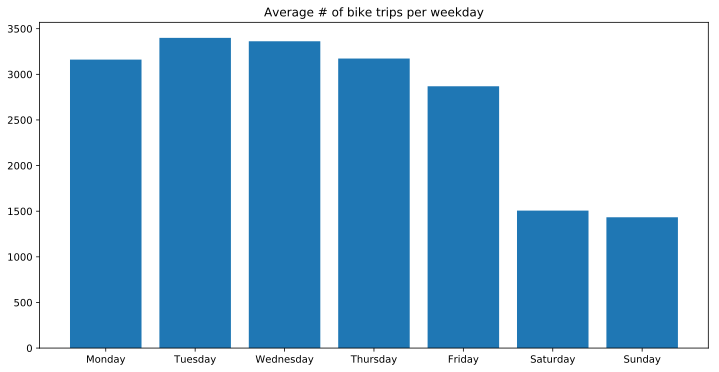

In [9]:
#visialize data
df_weekday = (df_merged
                 .groupby(['Weekday'], as_index = False)
                 .agg({'EW':'mean'})
                ) 
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday['Weekday'] = pd.Categorical(df_weekday['Weekday'], categories=cats, ordered=True)
df_weekday = df_weekday.sort_values('Weekday')

plt.figure(figsize=(12,6))
plt.rc('xtick') 
plt.rc('ytick') 

plt.bar(df_weekday.Weekday, df_weekday.EW)
plt.title('Average # of bike trips per weekday')
#plt.savefig('plot_trips_per_weekday.svg');

Text(0.5,1,'Average # of bike trips per month')

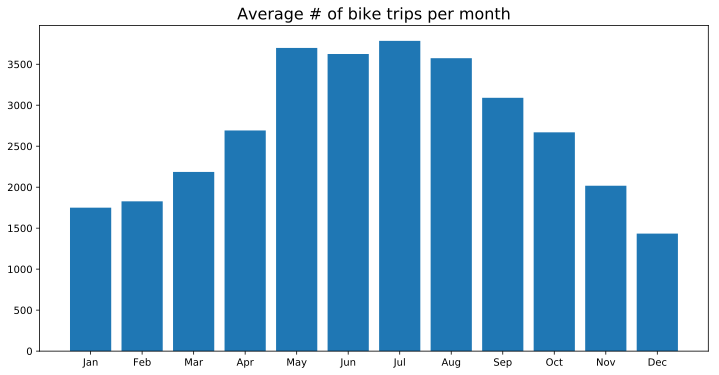

In [10]:
df_month = (df_merged
                 .groupby(['Month'], as_index = False)
                 .agg({'EW':'mean'})
                ) 
plt.figure(figsize=(12,6))
plt.rc('xtick') 
plt.rc('ytick') 

ticks_x = np.linspace(1, 12, 12)
vals_x = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x,vals_x)

plt.bar(df_month.Month, df_month.EW)
plt.title('Average # of bike trips per month',fontsize = 16)
#plt.savefig('plot_trips_per_month.svg');

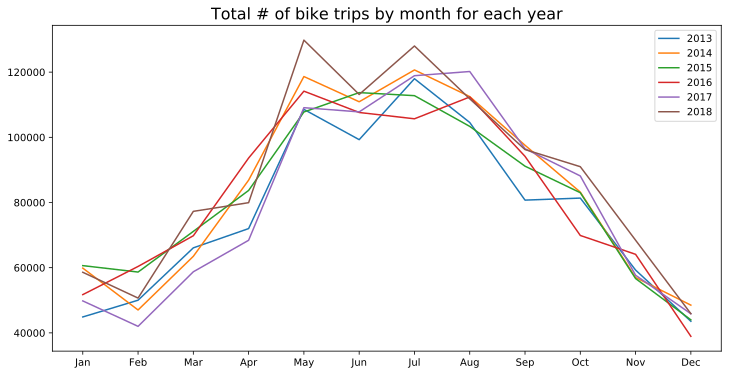

In [11]:
df_yymm = (df_merged
                 .groupby(['Year','Month'], as_index = False)
                 .agg({'EW':'sum'})
                ) 

plt.figure(figsize=(12,6))
plt.rc('xtick') 
plt.rc('ytick') 

ticks_x = np.linspace(1, 12, 12)
vals_x = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x,vals_x)


plt.title('Total # of bike trips by month for each year',fontsize = 16)

plt.plot(df_yymm[df_yymm.Year == 2013].Month, df_yymm[df_yymm.Year == 2013].EW)
plt.plot(df_yymm[df_yymm.Year == 2014].Month, df_yymm[df_yymm.Year == 2014].EW)
plt.plot(df_yymm[df_yymm.Year == 2015].Month, df_yymm[df_yymm.Year == 2015].EW)
plt.plot(df_yymm[df_yymm.Year == 2016].Month, df_yymm[df_yymm.Year == 2016].EW)
plt.plot(df_yymm[df_yymm.Year == 2017].Month, df_yymm[df_yymm.Year == 2017].EW)
plt.plot(df_yymm[df_yymm.Year == 2018].Month, df_yymm[df_yymm.Year == 2018].EW)
plt.legend(['2013','2014','2015','2016','2017','2018'])
#plt.savefig('plot_trips_per_month_year.svg');

## Select and normalize data for regression

In [12]:
selected_columns = ['EW','Temp-Avg','Temp_HiLo_delta','Precipitation','Snow_Depth'
               ,'sin_month','cos_month','Is_holiday','Weekday','Weekend_rain','Precip^2']

yX = df_merged[selected_columns]

yX = pd.get_dummies(yX)
yX.drop(columns=['Weekday_Sunday','Weekday_Saturday'],inplace=True)

yX.head()

,EW,Temp-Avg,Temp_HiLo_delta,Precipitation,Snow_Depth,sin_month,cos_month,Is_holiday,Weekend_rain,Precip^2,Weekday_Friday,Weekday_Monday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,678.0,34.0,14.0,0.00,0.0,0.5,0.866025,1,0,0.0000,0,0,0,1,0
1,1835.0,36.5,13.0,0.00,0.0,0.5,0.866025,0,0,0.0000,0,0,0,0,1
2,1803.0,36.5,15.0,0.16,0.0,0.5,0.866025,0,0,0.0256,0,0,1,0,0
3,1712.0,43.0,14.0,0.10,0.0,0.5,0.866025,0,0,0.0100,1,0,0,0,0
4,719.0,42.0,4.0,0.12,0.0,0.5,0.866025,0,1,0.0144,0,0,0,0,0


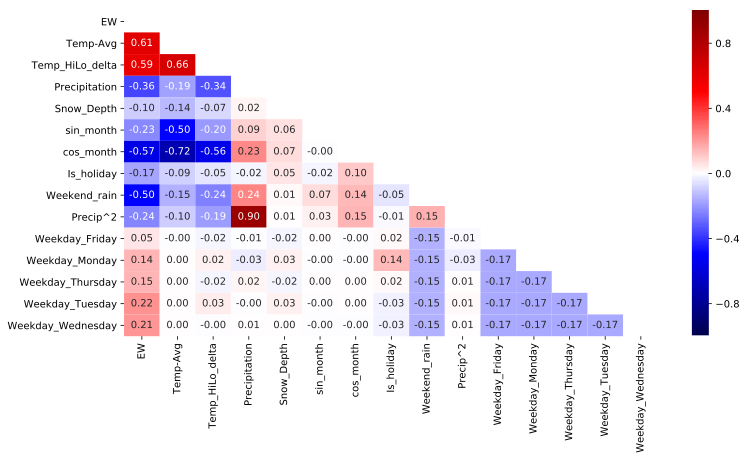

In [13]:
#product the heat map to look at variable correlations with each other and the dependent variable
plt.figure(figsize=(12,6))
mask = np.zeros_like(yX.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(yX.corr(), cmap="seismic", annot=True,fmt = '.2f', vmin=-1, vmax=1, mask=mask);

#### --define X, y, and the holdout test data sample

In [14]:
#split out X and y
y = yX.iloc[:,0]
X = yX.iloc[:,1:]

#hold out the test dataset - in this case, all of 2018
y_test = y[test_split:]
X_test = X[test_split:]

y_cv = y[:test_split]
X_cv = X[:test_split]

#### --normalize X_cv

In [15]:
std = StandardScaler()
std.fit(X_cv.values)

X_cv_scaled = std.transform(X_cv.values)

## Use cross-validation to select between Lasso and OLS regressions

#### --set up Lasso regression as the alternative to simple OLS

In [16]:
alphavec = 10**np.linspace(-2,2,200)
kf = KFold(n_splits=5, shuffle=True)

model_Lasso = LassoCV(alphas = alphavec, cv=kf)
model_Lasso.fit(X_cv_scaled, y_cv)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=KFold(n_splits=5, random_state=None, shuffle=True),
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

0.352970730273065


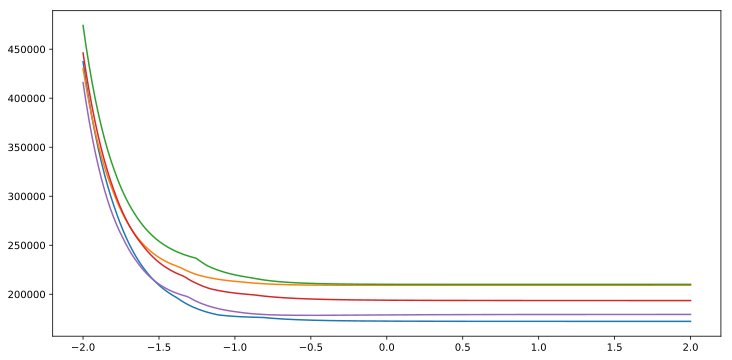

In [17]:
#visualize the Lasso alphas curve to ensure the range was appropriate
plt.figure(figsize=(12,6))
plt.plot(np.log10(alphavec), model_Lasso.mse_path_);
print(model_Lasso.alpha_)

In [18]:
# These are the (standardized) coefficients found
# when it refit using that best alpha - nothing is 0 now, which is great
list(zip(X_cv.columns, model_Lasso.coef_))

[('Temp-Avg', 243.0399926818373),
 ('Temp_HiLo_delta', 292.46183131177713),
 ('Precipitation', -476.41255761829115),
 ('Snow_Depth', -45.84268454667779),
 ('sin_month', -95.86106223403513),
 ('cos_month', -310.20323719019035),
 ('Is_holiday', -220.23679027771254),
 ('Weekend_rain', 57.91327151320547),
 ('Precip^2', 244.48816952659192),
 ('Weekday_Friday', 513.4871215377707),
 ('Weekday_Monday', 623.8943398249163),
 ('Weekday_Thursday', 630.0932743482629),
 ('Weekday_Tuesday', 677.8544370777146),
 ('Weekday_Wednesday', 682.5723448360189)]

#### --Now, run OLS via cross-validation and compare the results of the two models

In [19]:
model_OLS = LinearRegression()
#model_OLS.fit(X_cv_scaled, y_cv)

kf = KFold(n_splits=5, shuffle=True)

In [20]:
print(np.mean(cross_val_score(model_OLS, X_cv_scaled, y_cv, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(model_Lasso, X_cv_scaled, y_cv, cv=kf, scoring='r2')))

0.8837519705991254
0.8832702689214816


#### ---OLS wins!

## Test OLS residuals calculated on the whole cv set for any issues

#### --first, use statsmodels to generate the OLS to get the nicer output than from sklearn

In [21]:
selected_columns = ['EW','Temp_HiLo_delta','Temp-Avg','Precipitation','Snow_Depth'
               ,'sin_month','cos_month','Is_holiday','Weekday','Weekend_rain','Precip^2']

yX = df_merged[selected_columns]

yX = pd.get_dummies(yX)
yX.drop(columns=['Weekday_Sunday','Weekday_Saturday'],inplace=True)

#split out X and y
y = yX.iloc[:,0]
X = yX.iloc[:,1:]
X['Intercept'] = 1

#hold out the test dataset - in this case, all of 2018
y_test = y[test_split:]
X_test = X[test_split:]

y_cv = y[:test_split]
X_cv = X[:test_split]

#run the model
OLS_model = sm.regression.linear_model.OLS(y_cv,X_cv)
OLS_fit = OLS_model.fit()
OLS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EW   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1007.
Date:                Sat, 26 Jan 2019   Prob (F-statistic):               0.00
Time:                        08:51:16   Log-Likelihood:                -13684.
No. Observations:                1826   AIC:                         2.740e+04
Df Residuals:                    1811   BIC:                         2.748e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Temp_HiLo_delta      42.9330      2.185     19.648      0.000      38.647      47.219
Temp-Avg             22.1652      2.160     10.260      0.000      17.928      26.402
Precipitation     -1807.9453     99.177    -18.229      0.000   -2002.459   -1613.431
Snow_Depth         -239.8434     53.953     -4.445      0.000    -345.660    -134.026
sin_month          -136.4576     21.134     -6.457      0.000    -177.907     -95.008
cos_month          -438.5738     26.588    -16.495      0.000    -490.720    -386.427
Is_holiday        -1394.1137     65.854    -21.170      0.000   -1523.272   -1264.955
Weekend_rain        186.7210     42.140      4.431      0.000     104.074     269.368
Precip^2            734.5173     73.039     10.056      0.000     591.267     877.767
Weekday_Friday     1473.6465     37.536     39.260      0.000    1400.028    1547.265
Weekday_Monday     1792.1307     37.737     47.490      0.000    1718.119    1866.143
Weekday_Thursday   1806.9274     37.715     47.910      0.000    1732.959    1880.896
Weekday_Tuesday    1943.1772     37.450     51.887      0.000    1869.727    2016.627
Weekday_Wednesday  1956.7192     37.587     52.058      0.000    1883.001    2030.438
Intercept          -299.2538    110.613     -2.705      0.007    -516.197     -82.311
==============================================================================
Omnibus:                       31.761   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.406
Skew:                           0.118   Prob(JB):                     1.53e-12
Kurtosis:                       3.812   Cond. No.                         694.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### --residual plots

In [22]:
#1) merge the full input data with the output (predictions and residuals)

cv_pred = OLS_fit.predict(X_cv)
cv_resid = y_cv-cv_pred
cv_pred = cv_pred.rename('cv_pred')
cv_resid = cv_resid.rename('cv_resid')
cv_model_results = df_merged.loc[:test_split].join(cv_pred)
cv_model_results = cv_model_results.join(cv_resid)
cv_model_results.head()

,Date,East,West,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth,Weekday,Month,Year,sin_month,cos_month,Is_holiday,EW,Temp_HiLo_delta,Weekend_rain,Precip^2,cv_pred,cv_resid
0,2013-01-01,334.0,344.0,41.0,27.0,34.0,-6.8,31.0,0.0,0.00,0.0,0.0,Tuesday,1,2013,0.5,0.866025,1,678.0,14.0,0,0.0000,1156.443539,-478.443539
1,2013-01-02,931.0,904.0,43.0,30.0,36.5,-4.4,28.0,0.0,0.00,0.0,0.0,Wednesday,1,2013,0.5,0.866025,0,1835.0,13.0,0,0.0000,2576.579134,-741.579134
2,2013-01-03,913.0,890.0,44.0,29.0,36.5,-4.5,28.0,0.0,0.16,0.0,0.0,Thursday,1,2013,0.5,0.866025,0,1803.0,15.0,0,0.0256,2242.185801,-439.185801
3,2013-01-04,876.0,836.0,50.0,36.0,43.0,1.9,22.0,0.0,0.10,0.0,0.0,Friday,1,2013,0.5,0.866025,0,1712.0,14.0,0,0.0100,2107.063794,-395.063794
4,2013-01-05,316.0,403.0,44.0,40.0,42.0,0.8,23.0,0.0,0.12,0.0,0.0,Saturday,1,2013,0.5,0.866025,0,719.0,4.0,1,0.0144,335.715732,383.284268


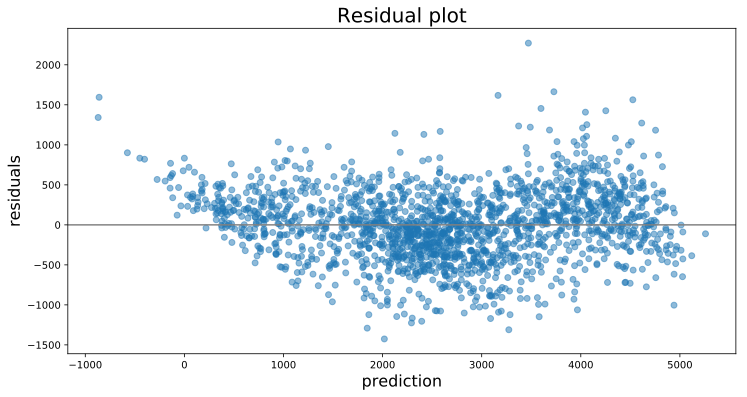

In [23]:
#2) Predictions vs. residuals

plt.figure(figsize=(12,6))
plt.scatter(cv_model_results.cv_pred,cv_model_results.cv_resid, alpha = 0.5)
plt.title("Residual plot", fontsize = 20)
plt.xlabel("prediction", fontsize = 16)
plt.ylabel("residuals", fontsize = 16)
plt.axhline(0, linestyle='-', color='grey')
#plt.savefig('plot_overall_resid.svg');

In [24]:
#look up the points on the far left
print(cv_model_results[cv_model_results.cv_pred < -500])

            Date   East   West  Temp-Max  Temp-Min  Temp-Avg  Departure   HDD  \
1460  2016-12-31  234.0  238.0      38.0      29.0      33.5       -7.2  31.0   
1461  2017-01-01  164.0  162.0      37.0      28.0      32.5       -8.3  32.0   
1825  2017-12-31  343.0  391.0      43.0      33.0      38.0       -2.7  27.0   

      CDD  Precipitation  New_Snow  Snow_Depth   Weekday  Month  Year  \
1460  0.0           0.03       0.0         0.0  Saturday     12  2016   
1461  0.0           0.43       3.0         2.0    Sunday      1  2017   
1825  0.0           0.00       0.0         0.0    Sunday     12  2017   

         sin_month  cos_month  Is_holiday     EW  Temp_HiLo_delta  \
1460 -2.449294e-16   1.000000           1  472.0              9.0   
1461  5.000000e-01   0.866025           0  326.0              9.0   
1825 -2.449294e-16   1.000000           1  734.0             10.0   

      Weekend_rain  Precip^2     cv_pred     cv_resid  
1460             1    0.0009 -869.866666  1341.86

In [25]:
#look up the the point with the highest residual
print(cv_model_results[cv_model_results.cv_resid > 2000])

           Date    East    West  Temp-Max  Temp-Min  Temp-Avg  Departure  HDD  \
500  2014-05-16  2599.0  3143.0      68.0      53.0      60.5        4.4  4.0   

     CDD  Precipitation  New_Snow  Snow_Depth Weekday  Month  Year  sin_month  \
500  0.0            0.0       0.0         0.0  Friday      5  2014        0.5   

     cos_month  Is_holiday      EW  Temp_HiLo_delta  Weekend_rain  Precip^2  \
500  -0.866025           0  5742.0             15.0             0       0.0   

       cv_pred   cv_resid  
500  3470.9689  2271.0311  


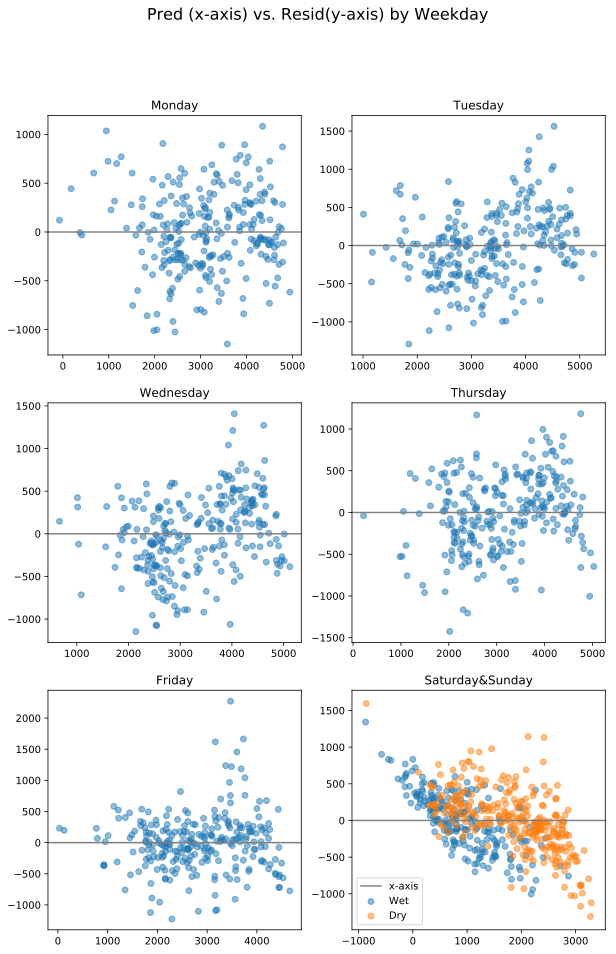

In [26]:
#3) Plot the same chart but highlight each day of the week
filtWet = ((cv_model_results.Weekday=='Saturday') | (cv_model_results.Weekday=='Sunday')) & \
(cv_model_results.Precipitation>0) 
filtDry = ((cv_model_results.Weekday=='Saturday') | (cv_model_results.Weekday=='Sunday')) & \
(cv_model_results.Precipitation==0) 

plt.figure(figsize=(10,15))
plt.suptitle('Pred (x-axis) vs. Resid(y-axis) by Weekday',fontsize = 16)

plt.subplot(3,2,1)
plt.scatter(cv_model_results[cv_model_results.Weekday=='Monday'].cv_pred
            ,cv_model_results[cv_model_results.Weekday=='Monday'].cv_resid, alpha = 0.5)
plt.title("Monday")
plt.axhline(0, linestyle='-', color='grey')
plt.subplot(3,2,2)
plt.scatter(cv_model_results[cv_model_results.Weekday=='Tuesday'].cv_pred
            ,cv_model_results[cv_model_results.Weekday=='Tuesday'].cv_resid, alpha = 0.5)
plt.title("Tuesday")
plt.axhline(0, linestyle='-', color='grey')
plt.subplot(3,2,3)
plt.scatter(cv_model_results[cv_model_results.Weekday=='Wednesday'].cv_pred
            ,cv_model_results[cv_model_results.Weekday=='Wednesday'].cv_resid, alpha = 0.5)
plt.title("Wednesday")
plt.axhline(0, linestyle='-', color='grey')
plt.subplot(3,2,4)
plt.scatter(cv_model_results[cv_model_results.Weekday=='Thursday'].cv_pred
            ,cv_model_results[cv_model_results.Weekday=='Thursday'].cv_resid, alpha = 0.5)
plt.title("Thursday")
plt.axhline(0, linestyle='-', color='grey')
plt.subplot(3,2,5)
plt.scatter(cv_model_results[cv_model_results.Weekday=='Friday'].cv_pred
            ,cv_model_results[cv_model_results.Weekday=='Friday'].cv_resid, alpha = 0.5)
plt.title("Friday")
plt.axhline(0, linestyle='-', color='grey')
plt.subplot(3,2,6)
plt.scatter(cv_model_results[filtWet].cv_pred
            ,cv_model_results[filtWet].cv_resid, alpha = 0.5)
plt.scatter(cv_model_results[filtDry].cv_pred
            ,cv_model_results[filtDry].cv_resid, alpha = 0.5)
plt.title("Saturday&Sunday")
plt.axhline(0, linestyle='-', color='grey')
plt.legend(['x-axis','Wet','Dry']);
#plt.savefig('plot_by_weekday.svg');

In [27]:
#look up those high and low weekend values to see if I can catch the pattern

filtHi = ((cv_model_results.Weekday=='Saturday') | (cv_model_results.Weekday=='Sunday')) \
& (cv_model_results.cv_pred > 3000)
filtLo = ((cv_model_results.Weekday=='Saturday') | (cv_model_results.Weekday=='Sunday')) \
& (cv_model_results.cv_pred < 0)

print(cv_model_results[filtHi])
print(cv_model_results[filtLo])

            Date    East    West  Temp-Max  Temp-Min  Temp-Avg  Departure  \
180   2013-06-30  1258.0  1488.0      93.0      63.0      78.0       14.7   
557   2014-07-12  1236.0  1244.0      90.0      62.0      76.0       10.6   
907   2015-06-27  1047.0  1163.0      92.0      63.0      77.5       14.7   
914   2015-07-04  1196.0  1247.0      92.0      59.0      75.5       11.4   
915   2015-07-05   911.0  1008.0      91.0      62.0      76.5       12.2   
928   2015-07-18  1088.0  1107.0      92.0      64.0      78.0       11.8   
929   2015-07-19   946.0  1017.0      95.0      63.0      79.0       12.7   
942   2015-08-01  1066.0  1153.0      92.0      60.0      76.0        9.1   
1251  2016-06-05  1001.0  1132.0      93.0      64.0      78.5       19.2   
1635  2017-06-24  1263.0  1183.0      89.0      61.0      75.0       12.8   
1636  2017-06-25  1094.0  1070.0      96.0      64.0      80.0       17.6   

      HDD   CDD  Precipitation  New_Snow  Snow_Depth   Weekday  Month  Year

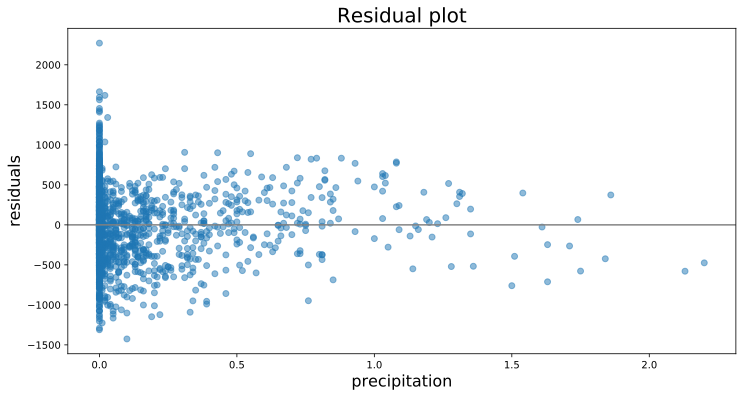

In [28]:
#4) Individual variables vs. residuals

plt.figure(figsize=(12,6))
plt.scatter(cv_model_results.Precipitation,cv_model_results.cv_resid, alpha = 0.5)
plt.title("Residual plot", fontsize = 20)
plt.xlabel("precipitation", fontsize = 16)
plt.ylabel("residuals", fontsize = 16)
plt.axhline(0, linestyle='-', color='grey')

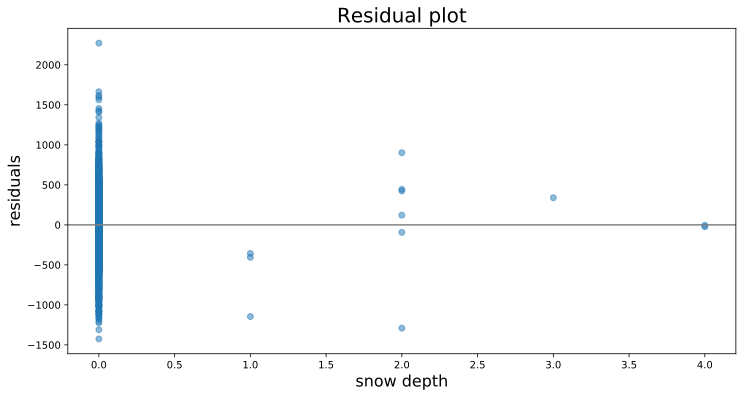

In [29]:
plt.figure(figsize=(12,6))
plt.scatter(cv_model_results.Snow_Depth,cv_model_results.cv_resid, alpha = 0.5)
plt.title("Residual plot", fontsize = 20)
plt.xlabel("snow depth", fontsize = 16)
plt.ylabel("residuals", fontsize = 16)
plt.axhline(0, linestyle='-', color='grey')

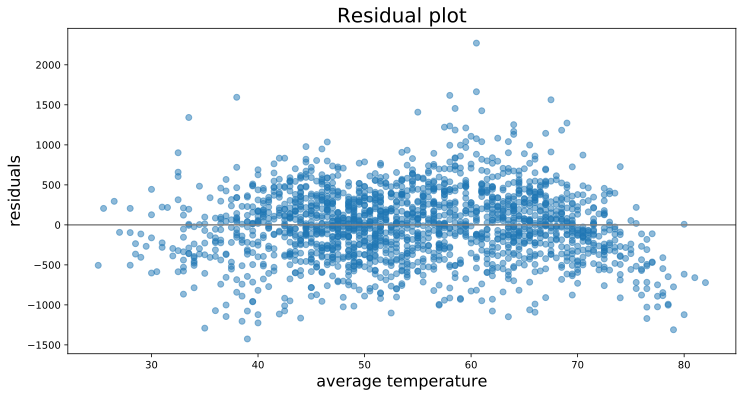

In [30]:
plt.figure(figsize=(12,6))
plt.scatter(cv_model_results['Temp-Avg'],cv_model_results.cv_resid, alpha = 0.5)
plt.title("Residual plot", fontsize = 20)
plt.xlabel("average temperature", fontsize = 16)
plt.ylabel("residuals", fontsize = 16)
plt.axhline(0, linestyle='-', color='grey')

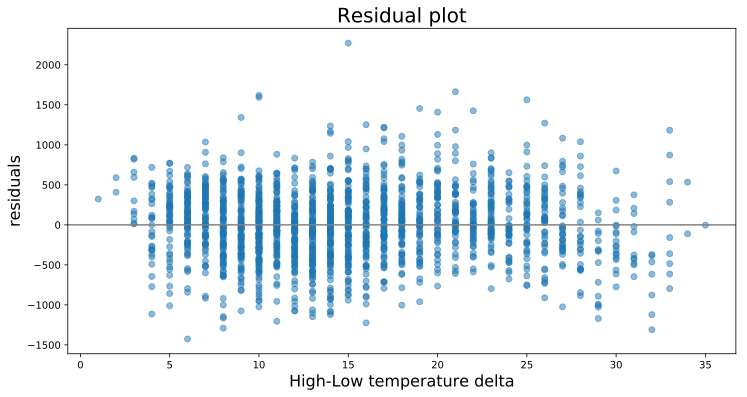

In [31]:
plt.figure(figsize=(12,6))
plt.scatter(cv_model_results['Temp_HiLo_delta'],cv_model_results.cv_resid, alpha = 0.5)
plt.title("Residual plot", fontsize = 20)
plt.xlabel("High-Low temperature delta", fontsize = 16)
plt.ylabel("residuals", fontsize = 16)
plt.axhline(0, linestyle='-', color='grey')

## Compare results to OLS without weather variables for interpretation

#### --no weather variables

In [32]:
selected_columns = ['EW','sin_month','cos_month','Is_holiday','Weekday']

yX_nW = df_merged[selected_columns]

yX_nW = pd.get_dummies(yX_nW)
yX_nW.drop(columns=['Weekday_Sunday','Weekday_Saturday'],inplace=True)

#split out X and y
y_nW = yX_nW.iloc[:,0]
X_nW = yX_nW.iloc[:,1:]
X_nW['Intercept'] = 1

#hold out the test dataset - in this case, all of 2018
y_test_nW = y_nW[test_split:]
X_test_nW = X_nW[test_split:]

y_cv_nW = y_nW[:test_split]
X_cv_nW = X_nW[:test_split]

#run the model
OLS_model_nW = sm.regression.linear_model.OLS(y_cv_nW,X_cv_nW)
OLS_fit_nW = OLS_model_nW.fit()
OLS_fit_nW.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EW   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     757.8
Date:                Sat, 26 Jan 2019   Prob (F-statistic):               0.00
Time:                        08:51:19   Log-Likelihood:                -14329.
No. Observations:                1826   AIC:                         2.868e+04
Df Residuals:                    1817   BIC:                         2.872e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
sin_month          -432.7753     20.582    -21.027      0.000    -473.142    -392.409
cos_month         -1007.0783     20.606    -48.873      0.000   -1047.492    -966.664
Is_holiday        -1382.7233     93.163    -14.842      0.000   -1565.442   -1200.005
Weekday_Friday     1409.7843     47.128     29.914      0.000    1317.353    1502.216
Weekday_Monday     1748.5701     47.543     36.779      0.000    1655.325    1841.815
Weekday_Thursday   1707.6204     47.128     36.234      0.000    1615.189    1800.051
Weekday_Tuesday    1890.6423     47.054     40.180      0.000    1798.357    1982.928
Weekday_Wednesday  1863.6612     47.054     39.607      0.000    1771.376    1955.947
Intercept          1465.3600     27.162     53.949      0.000    1412.088    1518.632
==============================================================================
Omnibus:                       15.853   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.840
Skew:                          -0.149   Prob(JB):                     8.11e-05
Kurtosis:                       3.399   Cond. No.                         6.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### --Now, compare both OLS with and without the data on the test data

In [33]:
#run the Weather model
test_pred = OLS_fit.predict(X_test)
print(f'R^2 score of the Weather-inclusive model on test data =: {r2_score(y_test, test_pred):.3f}')
print(f'MSE of the Weather-inclusive model on test data =: {mean_squared_error(y_test_nW, test_pred):.1f}')

R^2 score of the Weather-inclusive model on test data =: 0.849
MSE of the Weather-inclusive model on test data =: 298177.1


In [34]:
#run the non-Weather model
test_pred_nW = OLS_fit_nW.predict(X_test_nW)
print(f'R^2 score of the non-Weather model on test data =: {r2_score(y_test_nW, test_pred_nW):.3f}')
print(f'MSE of the non-Weather model on test data =: {mean_squared_error(y_test_nW, test_pred_nW):.1f}')

R^2 score of the non-Weather model on test data =: 0.765
MSE of the non-Weather model on test data =: 464376.0


In [35]:
#add weather-inclusive and non-weather model predictions to the full test dataset for illustration
test_resid = y_test-test_pred
test_resid_nW = y_test-test_pred_nW

test_pred = test_pred.rename('pred')
test_pred_nW = test_pred_nW.rename('pred_nW')

test_resid = test_resid.rename('resid')
test_resid_nW = test_resid_nW.rename('resid_nW')

test_results = df_merged.loc[test_split:].join(test_pred)
test_results = test_results.join(test_pred_nW)
test_results = test_results.join(test_resid)
test_results = test_results.join(test_resid_nW)
test_results.Date = test_results.Date.map(lambda x: pd.Timestamp(x))
test_results.reset_index(inplace=True, drop=True)
test_results.head()

,Date,East,West,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth,Weekday,Month,Year,sin_month,cos_month,Is_holiday,EW,Temp_HiLo_delta,Weekend_rain,Precip^2,pred,pred_nW,resid,resid_nW
0,2018-01-01,381.0,293.0,44.0,31.0,37.5,-3.3,27.0,0.0,0.00,0.0,0.0,Monday,1,2018,0.5,0.866025,1,674.0,13.0,0,0.0000,1040.042156,742.663868,-366.042156,-68.663868
1,2018-01-02,1539.0,959.0,44.0,34.0,39.0,-1.9,26.0,0.0,0.00,0.0,0.0,Tuesday,1,2018,0.5,0.866025,0,2498.0,10.0,0,0.0000,2489.650996,2267.459339,8.349004,230.540661
2,2018-01-03,1662.0,1165.0,49.0,33.0,41.0,0.0,24.0,0.0,0.00,0.0,0.0,Wednesday,1,2018,0.5,0.866025,0,2827.0,16.0,0,0.0000,2805.121562,2240.478196,21.878438,586.521804
3,2018-01-04,1545.0,1033.0,47.0,35.0,41.0,-0.1,24.0,0.0,0.13,0.0,0.0,Thursday,1,2018,0.5,0.866025,0,2578.0,12.0,0,0.0169,2260.978070,2084.437376,317.021930,493.562624
4,2018-01-05,1117.0,749.0,51.0,45.0,48.0,6.8,17.0,0.0,0.51,0.0,0.0,Friday,1,2018,0.5,0.866025,0,1866.0,6.0,0,0.2601,1316.870649,1786.601324,549.129351,79.398676


#### --plot the non-Weather and weather-inclusive predictions vs. actuals

Text(0.5,1,'Actuals vs. Predictions')

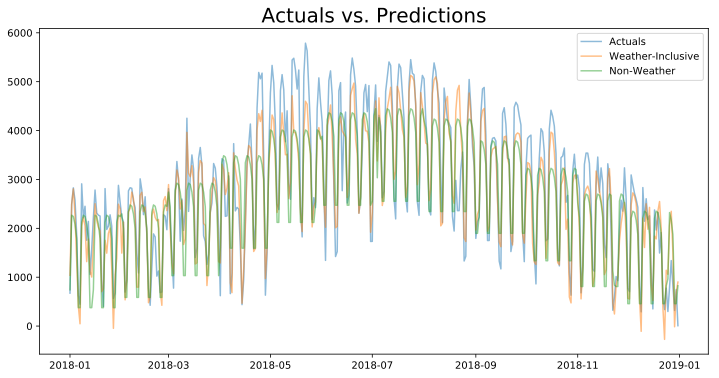

In [40]:
plt.figure(figsize=(12,6))
plt.plot(test_results.Date,test_results.EW, alpha = 0.5)
plt.plot(test_results.Date,test_results.pred, alpha = 0.5)
plt.plot(test_results.Date,test_results.pred_nW, alpha = 0.5)
plt.legend(['Actuals','Weather-Inclusive','Non-Weather'], fontsize = 10)
plt.title("Actuals vs. Predictions", fontsize = 20)
#plt.savefig('plot_test_pred_vs_act.svg');

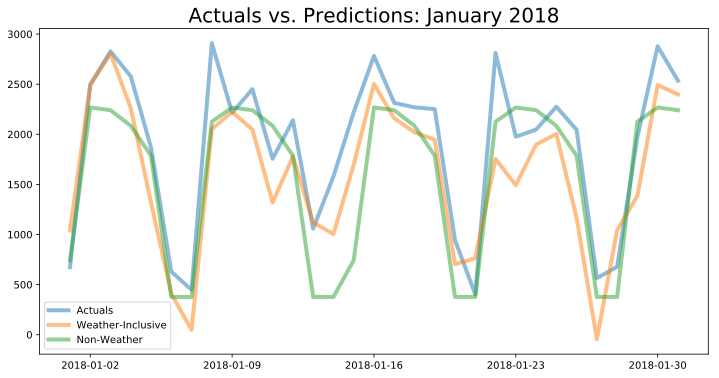

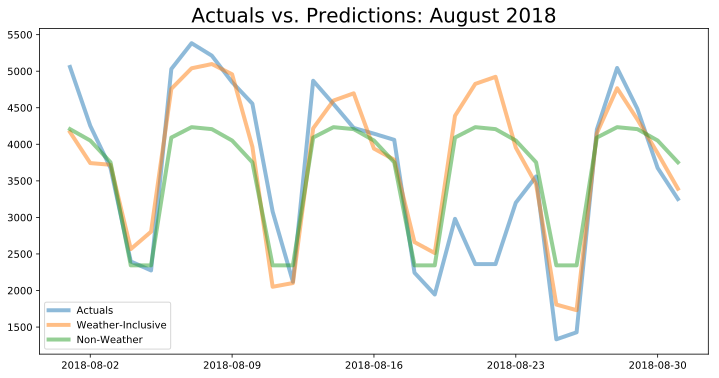

In [37]:
#zoom in
filt = (test_results.Month==1)

plt.figure(figsize=(12,6))
plt.plot(test_results[filt].Date,test_results[filt].EW, alpha = 0.5, linewidth=4)
plt.plot(test_results[filt].Date,test_results[filt].pred, alpha = 0.5, linewidth=4)
plt.plot(test_results[filt].Date,test_results[filt].pred_nW, alpha = 0.5, linewidth=4)
plt.legend(['Actuals','Weather-Inclusive','Non-Weather'])
plt.title("Actuals vs. Predictions: January 2018", fontsize = 20);


filt = (test_results.Month==8)

plt.figure(figsize=(12,6))
plt.plot(test_results[filt].Date,test_results[filt].EW, alpha = 0.5, linewidth=4)
plt.plot(test_results[filt].Date,test_results[filt].pred, alpha = 0.5, linewidth=4)
plt.plot(test_results[filt].Date,test_results[filt].pred_nW, alpha = 0.5, linewidth=4)
plt.legend(['Actuals','Weather-Inclusive','Non-Weather'])
plt.title("Actuals vs. Predictions: August 2018", fontsize = 20);


In [38]:
test_results['Abs resid'] = abs(test_results['resid'])
test_results['Abs resid_nW'] = abs(test_results['resid_nW'])
test_results['Pred-Pred_nW'] = test_results['pred'] - test_results['pred_nW']
test_results['Abs Pred-Pred_nW']= abs(test_results['Pred-Pred_nW'])
test_results['model % diff'] = test_results['Abs Pred-Pred_nW']/test_results['pred_nW']
test_results.head()

,Date,East,West,Temp-Max,Temp-Min,Temp-Avg,Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth,Weekday,Month,Year,sin_month,cos_month,Is_holiday,EW,Temp_HiLo_delta,Weekend_rain,Precip^2,pred,pred_nW,resid,resid_nW,Abs resid,Abs resid_nW,Pred-Pred_nW,Abs Pred-Pred_nW,model % diff
0,2018-01-01,381.0,293.0,44.0,31.0,37.5,-3.3,27.0,0.0,0.00,0.0,0.0,Monday,1,2018,0.5,0.866025,1,674.0,13.0,0,0.0000,1040.042156,742.663868,-366.042156,-68.663868,366.042156,68.663868,297.378288,297.378288,0.400421
1,2018-01-02,1539.0,959.0,44.0,34.0,39.0,-1.9,26.0,0.0,0.00,0.0,0.0,Tuesday,1,2018,0.5,0.866025,0,2498.0,10.0,0,0.0000,2489.650996,2267.459339,8.349004,230.540661,8.349004,230.540661,222.191657,222.191657,0.097991
2,2018-01-03,1662.0,1165.0,49.0,33.0,41.0,0.0,24.0,0.0,0.00,0.0,0.0,Wednesday,1,2018,0.5,0.866025,0,2827.0,16.0,0,0.0000,2805.121562,2240.478196,21.878438,586.521804,21.878438,586.521804,564.643366,564.643366,0.252019
3,2018-01-04,1545.0,1033.0,47.0,35.0,41.0,-0.1,24.0,0.0,0.13,0.0,0.0,Thursday,1,2018,0.5,0.866025,0,2578.0,12.0,0,0.0169,2260.978070,2084.437376,317.021930,493.562624,317.021930,493.562624,176.540694,176.540694,0.084695
4,2018-01-05,1117.0,749.0,51.0,45.0,48.0,6.8,17.0,0.0,0.51,0.0,0.0,Friday,1,2018,0.5,0.866025,0,1866.0,6.0,0,0.2601,1316.870649,1786.601324,549.129351,79.398676,549.129351,79.398676,-469.730675,469.730675,0.262919


In [39]:
test_results_agg = (test_results
                 #.groupby(['Month'], as_index = False)
                 .agg({'EW':'median', 'Abs resid':'median','Abs resid_nW':'median','Abs Pred-Pred_nW':'median'
                      ,'pred':'median','pred_nW':'median','model % diff':'median'})
                ) 
test_results_agg.head(10)

EW                  2717.000000
Abs resid            356.870421
Abs resid_nW         487.454628
Abs Pred-Pred_nW     241.520209
pred                2661.700159
pred_nW             2553.903031
model % diff           0.094917
dtype: float64